## Importing librairies

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from loading_data import *
import os
#from stats_tools import make_series_stationary


In [34]:
ncg_consumption, gaspool_consumption, the_consumption = read_consumption()
consumption_data = pd.concat([ncg_consumption.add(gaspool_consumption, fill_value=0), the_consumption])
df_consumption = consumption_data.to_frame(name='consumption')

# avoir le premier et le dernier index de la série
start_date = consumption_data.index[0].strftime("%Y-%m-%d")
end_date = consumption_data.index[-1].strftime("%Y-%m-%d")

weather = read_weather()
# afficher les colonnes du dataframe
print(weather.columns)
temp_2m_mean = weather["temperature_2m_mean (°C)"]
temp_2m_mean = temp_2m_mean[start_date:end_date] # avoir les dates des températures maximales à partir de start_date jusqu'à end_date


Index(['temperature_2m_max (°C)', 'temperature_2m_min (°C)',
       'temperature_2m_mean (°C)', 'sunshine_duration (h)',
       'wind_speed_10m_max (km/h)'],
      dtype='object')


In [91]:
consumption_data

2011-04-01    1233962.960
2011-04-02    1006977.403
2011-04-03    1025128.699
2011-04-04    1334227.003
2011-04-05    1362010.627
                 ...     
2024-10-27    1914459.771
2024-10-28    2186914.778
2024-10-29    2330071.796
2024-10-30    2312481.125
2024-10-31    2256990.688
Length: 4963, dtype: float64

In [60]:
#Conso mensuelle
gas_consumption_monthly = df_consumption.resample('M').sum()
temp_2m_mean_monthly = temp_2m_mean.loc[start_date:end_date].resample('M').sum()


In [61]:
gas_consumption_monthly

,consumption
2011-04-30,3.461649e+07
2011-05-31,3.179633e+07
2011-06-30,2.605131e+07
2011-07-31,2.729786e+07
2011-08-31,2.573426e+07
...,...
2024-06-30,4.282684e+07
2024-07-31,3.910594e+07
2024-08-31,3.715510e+07
2024-09-30,4.464442e+07


In [62]:
consumption_data.corr(temp_2m_mean)

-0.7536698980266934

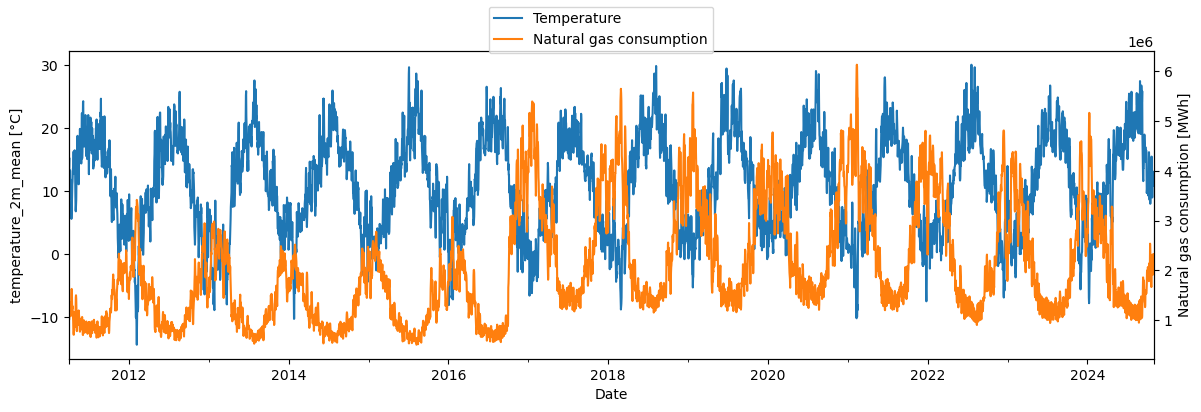

In [63]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean.loc[start_date:end_date].plot(ax=ax1, color="tab:blue")
consumption_data.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C]")
ax2.set_ylabel("Natural gas consumption [MWh]")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_daily.svg", format="svg", bbox_inches="tight")

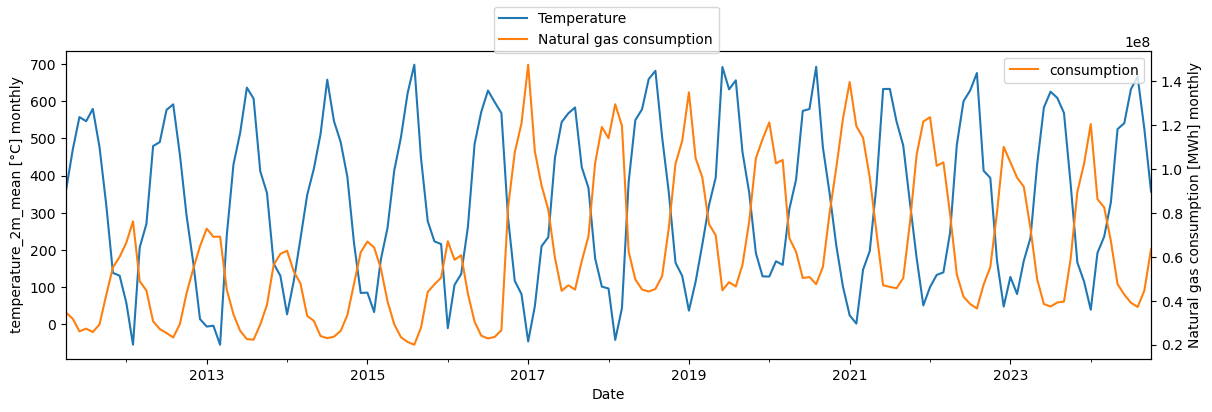

In [64]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean_monthly.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C] monthly")
ax2.set_ylabel("Natural gas consumption [MWh] monthly")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_monthly.svg", format="svg", bbox_inches="tight")

In [65]:
gas_consumption_monthly['consumption'].corr(temp_2m_mean_monthly)

-0.7603278565002137

In [66]:
#Nb d'heures ou 1m2 recoit plus de 120 Watts 
sunshine_dur = weather["sunshine_duration (h)"]
sunshine_dur = sunshine_dur.loc[start_date:end_date]
sunshine_dur

Date
2011-04-01     6.630931
2011-04-02     7.479119
2011-04-03    11.736578
2011-04-04     6.082192
2011-04-05     9.298789
                ...    
2024-10-27     5.493553
2024-10-28     2.000000
2024-10-29     0.000000
2024-10-30     2.199706
2024-10-31     2.540353
Name: sunshine_duration (h), Length: 4963, dtype: float64

In [67]:
consumption_data.corr(sunshine_dur)

-0.49751422900229897

In [68]:
#Nb de secondes ou 1m2 recoit plus de 120 Watts 
wind_speed_10m_max = weather["wind_speed_10m_max (km/h)"]
wind_speed_10m_max = wind_speed_10m_max.loc[start_date:end_date]
wind_speed_10m_max

Date
2011-04-01    25.5
2011-04-02    16.3
2011-04-03    15.8
2011-04-04    16.3
2011-04-05    17.3
              ... 
2024-10-27    22.5
2024-10-28    17.4
2024-10-29    16.4
2024-10-30    18.5
2024-10-31    21.9
Name: wind_speed_10m_max (km/h), Length: 4963, dtype: float64

In [69]:
consumption_data.corr(wind_speed_10m_max)

0.1315934701040311

In [70]:
sunshine_dur_monthly = sunshine_dur.resample('M').sum()
wind_speed_10m_max_monthly = wind_speed_10m_max.resample('M').sum()


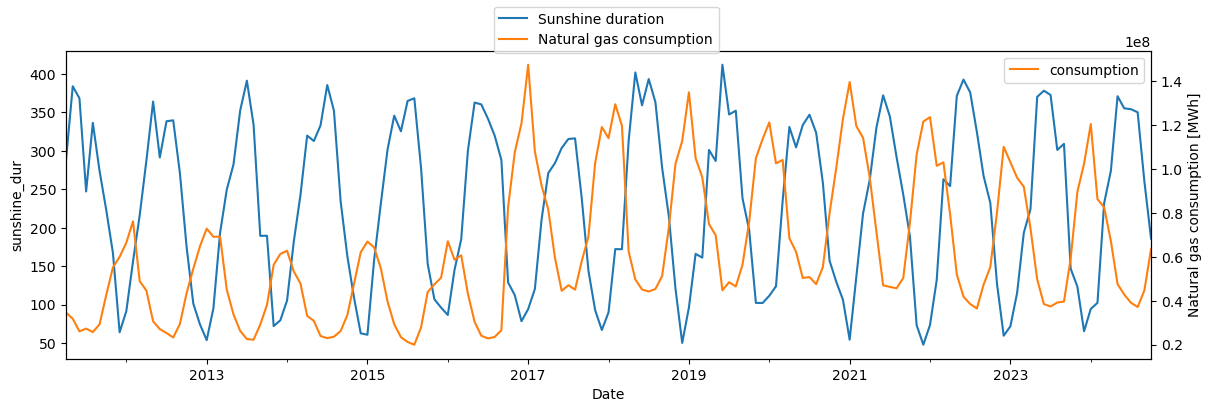

In [71]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

sunshine_dur_monthly.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly.plot(ax=ax2, color="tab:orange")

ax1.set_ylabel("sunshine_dur")
ax2.set_ylabel("Natural gas consumption [MWh]")

fig.legend(
    labels=["Sunshine duration", "Natural gas consumption"],

    loc="upper center",
)

os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/sunshine_duration_analysis.svg", format="svg", bbox_inches="tight")

In [72]:
gas_consumption_monthly['consumption'].corr(sunshine_dur_monthly)

-0.7083587317573444

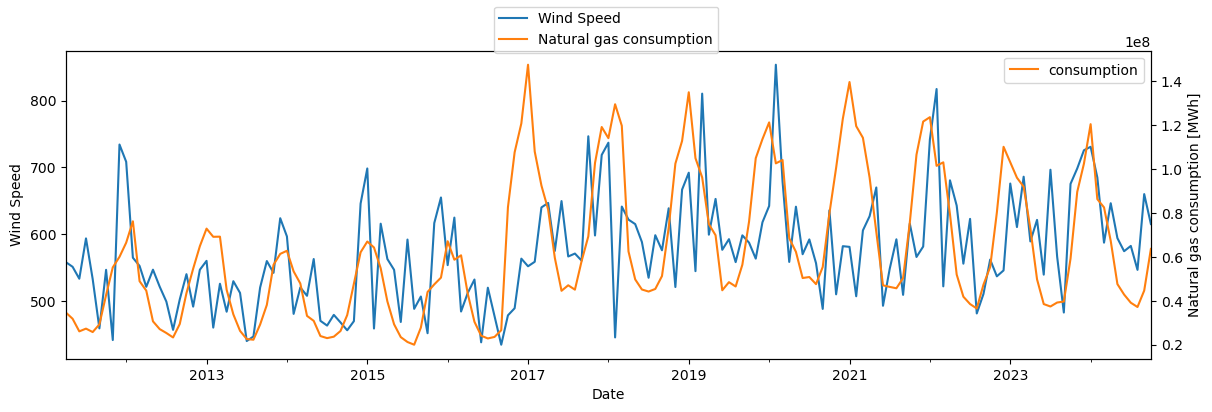

In [73]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

wind_speed_10m_max_monthly.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly.plot(ax=ax2, color="tab:orange")

ax1.set_ylabel("Wind Speed")
ax2.set_ylabel("Natural gas consumption [MWh]")

fig.legend(
    labels=["Wind Speed", "Natural gas consumption"],

    loc="upper center",
)

os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/wind_speed_analysis.svg", format="svg", bbox_inches="tight")

In [74]:
gas_consumption_monthly['consumption'].corr(wind_speed_10m_max_monthly)

0.4679374026173291

## Stationnarity analysis

In [84]:
from statsmodels.tsa.stattools import adfuller

# Fonction pour tester la stationnarité d'une série
def test_stationarity(series):
    result = adfuller(series.dropna())
    return result[1] < 0.05  # Retourne True si la série est stationnaire

# Fonction pour rendre une série stationnaire
def make_series_stationary(series, max_diff=5):
    diff_count = 0
    while not test_stationarity(series) and diff_count < max_diff:
        series = series.diff()
        diff_count += 1
    return series


In [85]:
#The goal is to see if we can improve the correlation by removing the trending/seasonality effect by making the time series stationnary

#gas_consumption_monthly = gas_consumption_monthly.fillna(method='ffill')
gas_consumption_monthly_st = make_series_stationary(gas_consumption_monthly['consumption'])

#wind_speed_10m_max_monthly = wind_speed_10m_max_monthly.fillna(method='ffill')
wind_speed_10m_max_monthly_st = make_series_stationary(wind_speed_10m_max_monthly)

#sunshine_dur_monthly = sunshine_dur_monthly.fillna(method='ffill')
sunshine_dur_monthly_st = make_series_stationary(sunshine_dur_monthly)


In [86]:
temp_2m_mean_monthly_st = make_series_stationary(temp_2m_mean_monthly)

In [87]:
temp_2m_mean_monthly_st

Date
2011-04-30      NaN
2011-05-31    109.0
2011-06-30     87.9
2011-07-31    -11.1
2011-08-31     33.0
              ...  
2024-06-30     15.7
2024-07-31     92.0
2024-08-31     33.1
2024-09-30   -140.3
2024-10-31   -168.9
Freq: M, Name: temperature_2m_mean (°C), Length: 163, dtype: float64

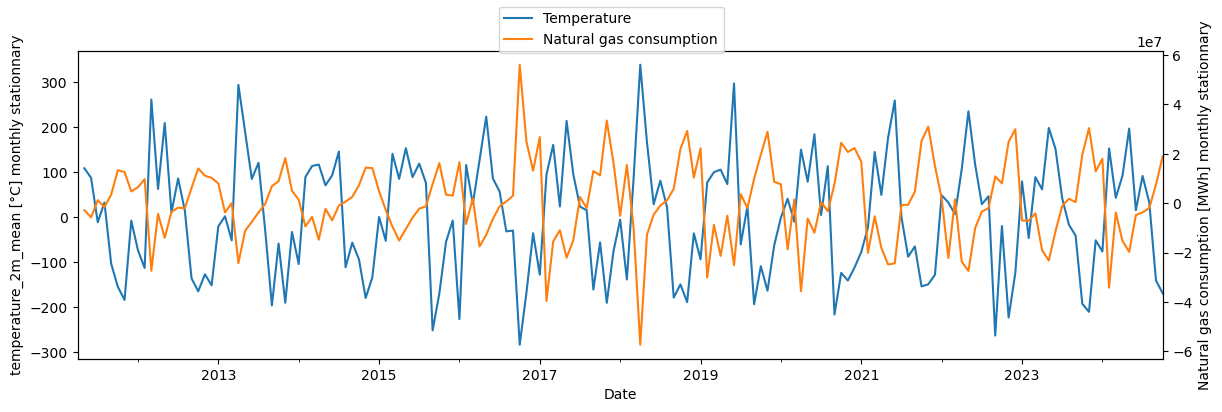

In [88]:
fig, ax1 = plt.subplots(figsize=(14, 4))
ax2 = ax1.twinx()

# For both, only show data in 2021 and 2022
temp_2m_mean_monthly_st.plot(ax=ax1, color="tab:blue")
gas_consumption_monthly_st.plot(ax=ax2, color="tab:orange")

# Labels and legend
ax1.set_ylabel("temperature_2m_mean [°C] monthly stationnary")
ax2.set_ylabel("Natural gas consumption [MWh] monthly stationnary")

# Legend for both plots in one
fig.legend(
    labels=["Temperature", "Natural gas consumption"],

    loc="upper center",
)

# Create directory if it does not exist
os.makedirs("diagrams", exist_ok=True)

# Save plot
fig.savefig("diagrams/temp_conso_monthly_stationnary.svg", format="svg", bbox_inches="tight")

In [90]:
gas_consumption_monthly_st.corr(temp_2m_mean_monthly_st)

-0.8439729196085272